In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader

from src.datamanager import DataManager
from src.plotting import emostring

The emotion labels for each image are accessed like this:

In [ ]:
labels_filename = "../Dataset/list_patition_label.txt"  #  Must include relative path
labels_df = pd.read_csv(
    labels_filename, 
    sep=" ", 
    header=None, 
    names=["filename", "emolabel"]
    )

print(labels_df.iloc[0, 0], labels_df.iloc[0, 1])

labels_df

train_00001_aligned.jpg 5


,filename,emolabel
0,train_00001_aligned.jpg,5
1,train_00002_aligned.jpg,5
2,train_00003_aligned.jpg,4
3,train_00004_aligned.jpg,4
4,train_00005_aligned.jpg,5
...,...,...
15334,test_3064_aligned.jpg,7
15335,test_3065_aligned.jpg,7
15336,test_3066_aligned.jpg,7
15337,test_3067_aligned.jpg,7


Train-test split is done like this:

In [3]:
train_df = labels_df[labels_df["filename"].str.startswith("train")].reset_index(drop=True)
test_df  = labels_df[labels_df["filename"].str.startswith("test")].reset_index(drop=True)

train_df

,filename,emolabel
0,train_00001_aligned.jpg,5
1,train_00002_aligned.jpg,5
2,train_00003_aligned.jpg,4
3,train_00004_aligned.jpg,4
4,train_00005_aligned.jpg,5
...,...,...
12266,train_12267_aligned.jpg,7
12267,train_12268_aligned.jpg,7
12268,train_12269_aligned.jpg,7
12269,train_12270_aligned.jpg,7


The training set can be further split up to make a validation set:

In [4]:
seed = 0

train_split_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=seed,
    stratify=train_df["emolabel"]
)

train_split_df = train_split_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_split_df

,filename,emolabel
0,train_09073_aligned.jpg,4
1,train_04564_aligned.jpg,5
2,train_12226_aligned.jpg,7
3,train_02341_aligned.jpg,4
4,train_01844_aligned.jpg,4
...,...,...
9811,train_09267_aligned.jpg,2
9812,train_10082_aligned.jpg,7
9813,train_08361_aligned.jpg,5
9814,train_08045_aligned.jpg,1


The images are accessed like this:

Anger


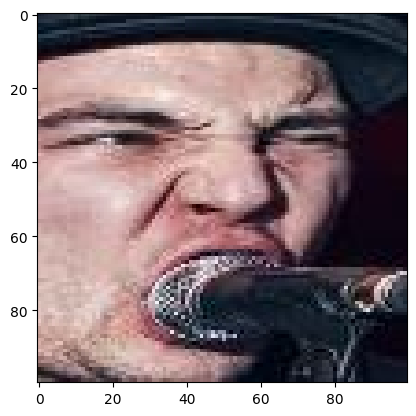

In [ ]:
dataset_dir = "../Dataset/aligned/"    # Relative path to folder containing images
data = DataManager(labels_df, dataset_dir)

ind = 420

emolabel = data[ind]["emolabel"]
print(emostring(emolabel))      #  Emostring converts 5 --> "Anger" (see Cell below)
plt.imshow(data[ind]["image"])


After going through `DataManager`, the emotion labels are now zero indexed $(\{1,2,\dots, 7\} \to \{0, 1, \dots, 6\})$ . Don't forget this!

In [6]:
ind = 420
print(f"Directly from dataframe: {labels_df.iloc[ind, 1]}")
print(f"After going through DataManager: {data[ind]["emolabel"]}")

emostring(data[ind]["emolabel"], zeroindex=True)  #  use zeroindex=False if converting directly from dataframe

Directly from dataframe: 6
After going through DataManager: 5


'Anger'

We want to do some transformations of the image data in order for PyTorch to run efficiently, and for the training to perform well. This is done in this manner:

In [10]:
from src.transformations import ToTensorSample, NormalizeSample
from torchvision import transforms

# Transforms data to reshaped pytorch tensors and pseudo-normalizes (values in [-1, 1])
transform = transforms.Compose([
    ToTensorSample(),
    NormalizeSample(),  
])

transformed_data = DataManager(labels_df, dataset_dir, transform)
transformed_data[ind]["image"]  #  Values were in [0, 255] before the transformation. 
# The values printed are all negative because the corners of the image are dark.

tensor([[[-0.8275, -0.7882, -0.7333,  ..., -0.9765, -0.9529, -0.9373],
         [-0.7569, -0.7412, -0.7255,  ..., -0.9686, -1.0000, -1.0000],
         [-0.7255, -0.7020, -0.6706,  ..., -0.8353, -0.9373, -0.9843],
         ...,
         [-0.7725, -0.7804, -0.7176,  ..., -0.8902, -0.8902, -0.8824],
         [-0.4275, -0.5608, -0.6078,  ..., -0.8824, -0.8824, -0.8745],
         [-0.0745, -0.2157, -0.2157,  ..., -0.8745, -0.8667, -0.8667]],

        [[-0.7725, -0.7333, -0.6784,  ..., -0.9137, -0.8902, -0.8745],
         [-0.6863, -0.6706, -0.6549,  ..., -0.9059, -0.9529, -0.9608],
         [-0.6314, -0.6078, -0.5765,  ..., -0.7725, -0.8745, -0.9216],
         ...,
         [-0.8118, -0.8196, -0.7804,  ..., -0.8431, -0.8431, -0.8353],
         [-0.4902, -0.6235, -0.6863,  ..., -0.8353, -0.8353, -0.8275],
         [-0.1373, -0.2784, -0.2941,  ..., -0.8275, -0.8196, -0.8196]],

        [[-0.6471, -0.6078, -0.5529,  ..., -0.8118, -0.7882, -0.7725],
         [-0.5686, -0.5529, -0.5373,  ..., -0

Finally, the pytorch dataloader allows shuffling and batching of the data.

In [ ]:
rng = torch.Generator()
rng.manual_seed(0)  #  For reproducibility
loader = DataLoader(transformed_data, batch_size=4, shuffle=True, generator=rng)
loader

Figure for the report:

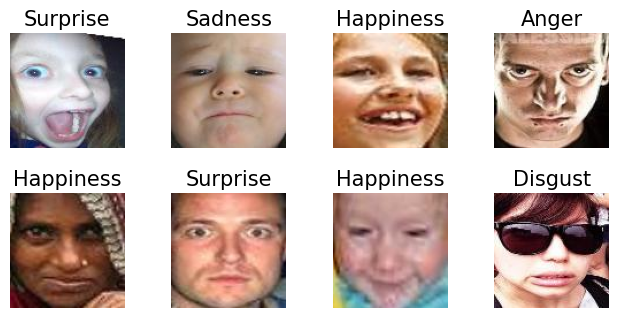

In [ ]:
fig = plt.figure()

import numpy as np
rng = np.random.default_rng(seed=2)

for i in range(0, 8):
    sample = data[rng.integers(0, 15339)]
    ax = plt.subplot(2, 4, i + 1)
    plt.tight_layout()
    ax.set_title(emostring(sample["emolabel"]), fontsize=15)
    ax.axis('off')
    plt.imshow(sample['image'])
plt.subplots_adjust(hspace=-0.4)
# plt.savefig("../Figures/dataset_samples.pdf", bbox_inches="tight")
plt.show()